### ライブラリのimport

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 解析用の元データを読み込み

In [235]:
df = pd.read_excel('preprocessed_train_data.xlsx')
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi,age_era
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,80
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1,60
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,40
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,50
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obesity class3,50


## 　新たな特徴量を作成

#### 体表面積を作成　　

体表面積 (m2
 )=0.007184×身長(cm) 
^0.725
 ×体重(kg)^
0.425

In [236]:
# Define a function to calculate body surface area
def calculate_bsa(height_cm, weight_kg):
    bsa = 0.007184 * (height_cm ** 0.725) * (weight_kg ** 0.425)
    return bsa

# Calculate body surface area for each row in the data
df['body_surface_area'] = calculate_bsa(df['height_cm'], df['weight_kg'])

# Display the first few rows of the data
df.head()


,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi,age_era,body_surface_area
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,80,1.421484
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1,60,1.797322
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,40,1.848150
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,50,1.901449
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obesity class3,50,2.256766


### scan_areaとscan_method(例：胸部CTx単純)をクロス集計

In [237]:
# クロス集計表の出現割合
cat_1 = 'scan_area'
cat_2 = 'scan_method'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとgenderのクロス集計

In [238]:
# クロス集計表の出現割合
cat_1 = 'category_bmi'
cat_2 = 'gender'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとage_eraのクロス集計

In [239]:
# クロス集計表の出現割合
cat_1 = 'age_era'
cat_2 = 'category_bmi'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

In [240]:
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,scan_area,scan_method,bmi,bmr,category_bmi,age_era,body_surface_area,rate_scan_area x scan_method,rate_category_bmi x gender,rate_age_era x category_bmi
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,胸部CT,単純,21.82,1000.01,normal weight,80,1.421484,0.965573,0.285877,0.643761
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,胸部CT,単純,27.85,1487.40,obesity class1,60,1.797322,0.965573,0.845044,0.259048
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,胸部CT,単純,21.46,1581.27,normal weight,40,1.848150,0.965573,0.714123,0.614739
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,胸部CT,単純,21.13,1588.26,normal weight,50,1.901449,0.965573,0.714123,0.501666
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,胸部CT,単純,36.57,2130.73,obesity class3,50,2.256766,0.965573,0.685714,0.014755


### 各年代の性別ごとのBMIの中央値を作成し、それを新たな特徴量とする

In [241]:
median_bmi = df.groupby(['age_era', 'gender'])['bmi'].median().to_dict()

In [242]:
df['age_era_gender_bmi'] = df.apply(lambda row: median_bmi[row['age_era'], row['gender']], axis=1)

### 各年代の性別ごとのBMRの中央値を作成し、それを新たな特徴量とする 

In [243]:
median_bmr = df.groupby(['age_era', 'gender'])['bmr'].median().to_dict()
df['age_era_gender_bmr'] = df.apply(lambda row: median_bmr[row['age_era'], row['gender']], axis=1)

In [244]:
median_bsa = df.groupby(['age_era', 'gender'])['body_surface_area'].median().to_dict()
df['age_era_gender_bsa'] = df.apply(lambda row: median_bsa[row['age_era'], row['gender']], axis=1)

### 数値カラムに対する変換

* 身長は何かしら変換を加えて正規分布に近づけてみるのも良いかも(Box-Cox変換)
* age_era_gender_bmiとbody_surface_areもBox-Cox変換等の非線形処理をしても良い

In [191]:
drops = ['accession', 'scan protocol', 'target region', 'scan series', 
         'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
         'nomial total collimation width', 'exposure time per rotation',
         'exposure time', 'DLP', 'study_date', 'id']
sns.pairplot(df.drop(drops, axis=1), hue='age_era')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f54ecfb09d0> (for post_execute):


KeyboardInterrupt: 

### Clusterで分類、KMeansを使う

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


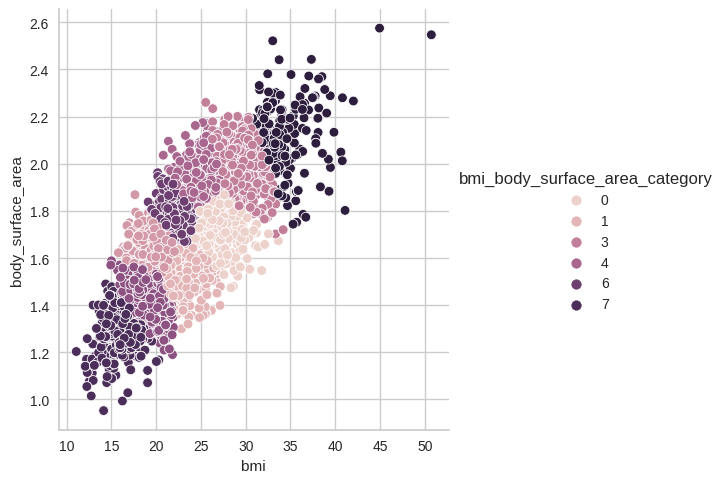

In [246]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['bmi', 'body_surface_area']]
X_std = sc.fit_transform(X)

df['bmi_body_surface_area_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='bmi', y='body_surface_area', hue='bmi_body_surface_area_category', data=df);

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


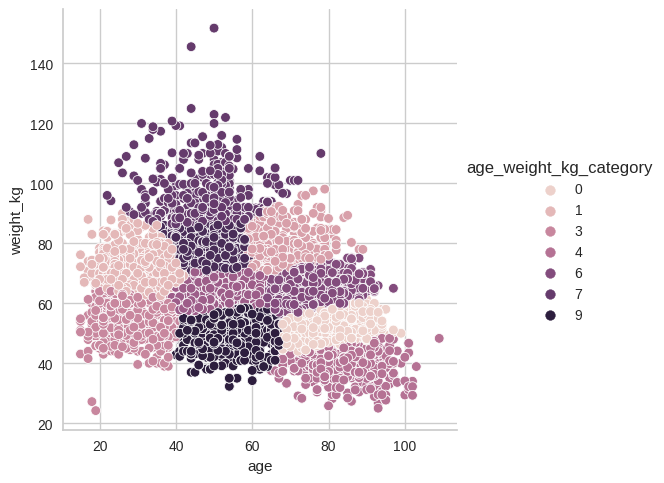

In [247]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['age', 'weight_kg']]
X_std = sc.fit_transform(X)

df['age_weight_kg_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='age', y='weight_kg', hue='age_weight_kg_category', data=df);

In [248]:
df.to_excel('feature_engineer_train.xlsx', index=False)

In [212]:
from yellowbrick.cluster import KElbowVisualizer

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/clust

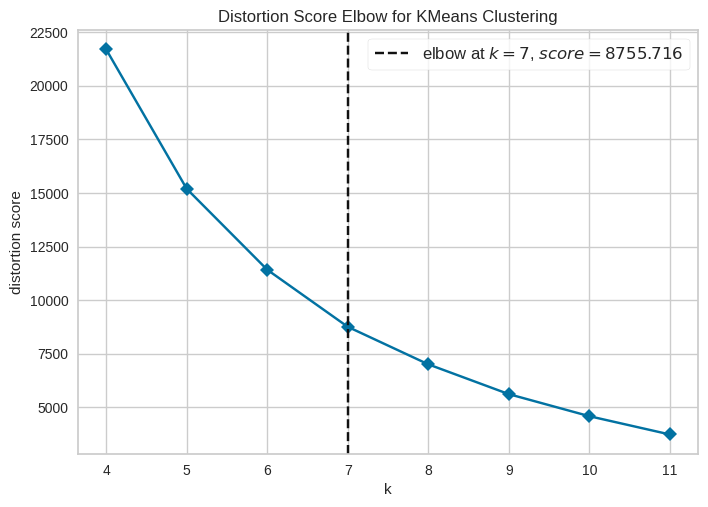

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [213]:
k_means = KMeans(random_state=42)

visualizer = KElbowVisualizer(k_means, k=(4, 12), metric='distortion', timings=False)
visualizer.fit(df.loc[:, ['bmi', 'body_surface_area']])
visualizer.show()

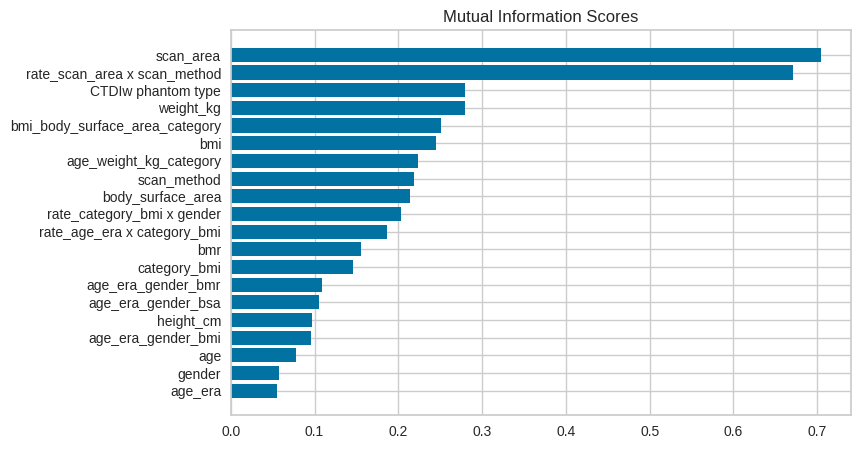

In [218]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 前処理をして相互情報量を計算
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = [ 'scan_area', 'category_bmi']
oe_columns = ['CTDIw phantom type','gender', 'scan_method']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

df.drop(drops, axis=1)

drops = ['Mean CTDIvol', 'accession', 'scan protocol', 'target region', 'scan series', 
         'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
         'nomial total collimation width', 'exposure time per rotation',
         'exposure time', 'Mean CTDIvol', 'DLP', 'study_date', 'id']

target = 'Mean CTDIvol'
mi_scores = make_mi_scores(df.drop(drops, axis=1), df[target], 'auto')

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)